# Analysis of simulated IP and temperature grouped by latitude

### Import libraries

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.transforms as tf
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import cm, colormaps, colors, transforms

from functools import cache
import cartopy.crs as ccrs

### Helper functions, variables and classes

In [2]:
month_name = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]

In [3]:
area_factor = (
    np.cos(np.arange(180) * np.pi / 180) - np.cos(np.arange(1, 181) * np.pi / 180)
) / 2

In [4]:
def std_error(avg_val, avg_sqr, counter):
    """
    Estimate the standard error from the average value
    and the average value of the square.
    
    :param avg_val: the average value
    :param avg_sqr: the average square value
    :param counter: the size of the sample
    
    :return: the standard error
    """

    return np.sqrt((avg_sqr - avg_val**2) / (counter - 1))

In [5]:
class LatitudeBand():
    """
    Represents a latitude band object with specific 
    latitude range and model information

    Attributes:
        slice (slice): slice for the latitude range
        indices (tuple): indices within the latitude range
        model (str): model associated with the latitude band
        color (str): color associated with the latitude band.
    """
    def __init__(self, expression, model=None):
        """
        Initializes a LatitudeBand object with the given latitude 
        expression and model.

        Args:
            expression (str): latitude range expr. like '0-8S', '8N-8S'
            model (str, optional): 'WRF' or 'INMCM', defaults to None
        """

        # split the expression into two parts 
        # and replace "0" with "0S" if necessary
        s1, s2 = [s if s != "0" else "0S" for s in expression.split("-")]
        assert all(s[-1] in "NS" and s[:-1].isdigit() for s in [s1, s2])

        # calculate values for the latitude bands 
        # taking into account direction
        N1 = int(s1[:-1]) * (-1 if s1[-1] == "S" else 1)
        N2 = int(s2[:-1]) * (-1 if s2[-1] == "S" else 1)
        
        # format latitude values for display using thin spaces
        p1 = f"0°" if N1 == 0 else f"{abs(N1):d}° {'S' if N1 < 0 else 'N'}"
        p2 = f"0°" if N2 == 0 else f"{abs(N2):d}° {'S' if N2 < 0 else 'N'}"

        # set color for each latitude band
        Z = (N1 + N2) / 2
        cmap = colormaps.get_cmap('tab20')
        if 0 < Z < 9:
            self.color = cmap(7 / 40)
        elif -9 < Z < 0:
            self.color = cmap(5 / 40)
        elif -18 < Z < -9:
            self.color = cmap(39 / 40)
        elif -90 < Z < -18:
            self.color = cmap(37 / 40)
        elif 9 < Z < 18:
            self.color = cmap(35 / 40)
        elif 18 < Z < 90:
            self.color = cmap(33 / 40)

        # ensure the model is valid and set degrees 
        # and central index based on the model
        assert model in ["WRF", "INMCM"]
        degrees = 1 if model == "WRF" else 1.5
        central_idx = 90 if model == "WRF" else 60

        # check that latitude values are divisible 
        # by the appropriate degrees
        assert all(N % degrees == 0 for N in [N1, N2])

        # convert latitude values to indices and sort them
        N1, N2 = sorted([int(N // degrees + central_idx) for N in [N1, N2]])

        # create a slice for the latitude range 
        # and generate indices within that range
        self.slice = slice(N1, N2, 1)
        self.indicies = tuple(np.arange(*self.slice.indices(1000000)).tolist())

        # store latitude bands model and prettify title
        self.model = model
        self.title = f"{p1}–{p2}" # like 9° S–18° S

### Loading precalculated arrays

In [6]:
wrf_N_days = 4992
inm_N_days = 3650

In [7]:
wrf_dt_indicies = np.array(
    [dt.date(1980, 1, 1) + dt.timedelta(i * 3) for i in range(wrf_N_days)]
)

inm_dt_indicies = np.array(
    [dt.date(2022, 1, 1) + dt.timedelta(i % 365) for i in range(inm_N_days)]
)

In [8]:
wrf_LATxMON_t2 = np.load("./data/WRF/WRF_T2_LATxMON.npy")

wrf_LATxMON_ip = {
    key: np.load(f"./data/WRF/WRF_IP_{parameters}_LATxMON.npy")
    for key, parameters in zip([500, 800, 1000, 1200],
                              ["500_T2_25", "800", "1000", "1200"])
}

inm_LATxMON_ip = {
    key: np.load(f"./data/INMCM/INMCM_IP_{parameters}_LATxMON.npy")
    for key, parameters in zip([800, 1000, 1200],
                              ["800", "1000", "1200"])
}

wrf_hourly_total_ip = {
    key: np.load(f"./data/WRF/WRF_HOURLY_TOTAL_IP_{parameters}.npy")
    for key, parameters in zip([500, 800, 1000, 1200],
                              ["500_T2_25", "800", "1000", "1200"])
}

inm_hourly_total_ip = {
    key: np.load(f"./data/INMCM/INMCM_HOURLY_TOTAL_IP_{parameters}.npy")
    for key, parameters in zip([800, 1000, 1200],
                              ["800", "1000", "1200"])
}

### Figure 4

In [9]:
band_names = ["0-9N", "0-9S", "9S-18S", "18S-90S", "9N-18N", "18N-90N"]
wrf_bands = [LatitudeBand(t, model="WRF") for t in band_names]
inmcm_bands = [LatitudeBand(t, model="INMCM") for t in band_names]

bar_data = np.zeros((6, len(band_names), 12))
# (axes, strips, months)

for j, cape in enumerate([800, 1000, 1200]):
    ax_idx = j * 2
    for i, band in enumerate(wrf_bands):
        bar_data[ax_idx, i] = wrf_LATxMON_ip[cape][band.slice].sum(axis=0)

    ax_idx = j * 2 + 1
    for i, band in enumerate(inmcm_bands):
        bar_data[ax_idx, i] = inm_LATxMON_ip[cape][band.slice].sum(axis=0)

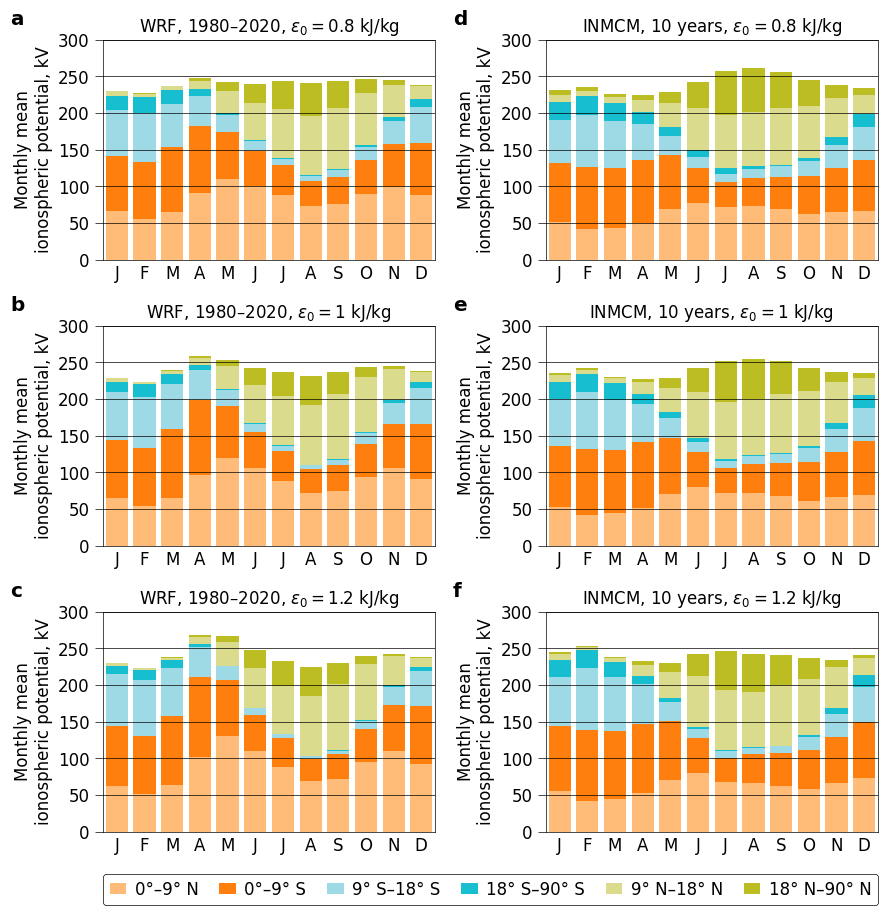

In [10]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(6)]
for n in range(6):
    ax[n] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))

low = [0e3] * 6
high = [300e3] * 6
step = [50e3] * 6
coeff = [1e3] * 6
caption = ['WRF, 1980–2020, $\\varepsilon_0 = 0.8$ kJ/kg',
           'INMCM, 10 years, $\\varepsilon_0 = 0.8$ kJ/kg',
           'WRF, 1980–2020, $\\varepsilon_0 = 1$ kJ/kg',
           'INMCM, 10 years, $\\varepsilon_0 = 1$ kJ/kg',
           'WRF, 1980–2020, $\\varepsilon_0 = 1.2$ kJ/kg',
           'INMCM, 10 years, $\\varepsilon_0 = 1.2$ kJ/kg']
lab = ['18° S–90° S',
       '9° S–18° S',
       '0°–9° S',
       '0°–9° N',
       '9° N–18° N',
       '18° N–90° N']
# thin spaces (' ') are used between ‘°’ signs and letters

for n in range(6):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis='y')
    ax[n].tick_params(length=0, width=0.5, axis='x')
    ax[n].grid(color='0.', linewidth=0.5, axis='y')

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize='large', va='top')

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize='large')
    ax[n].set_ylabel('Monthly mean\nionospheric potential, kV',
                     fontsize='large')

    ax[n].set_title(caption[n], fontsize='large')

fig.align_ylabels([ax[0], ax[2], ax[4]])
fig.align_ylabels([ax[1], ax[3], ax[5]])


for n in range(6):
    bottom_data = np.zeros(12)
    for k in range(len(band_names)):
        data = bar_data[n, k]
        ax[n].bar(
            np.arange(12),
            data,
            0.8,
            color=wrf_bands[k].color,
            bottom=bottom_data,
            label=wrf_bands[k].title,
        )
        bottom_data += data
        

for n in range(6):
    ax[n].text(-0.28, 1.05, chr(ord('a') + 3 * (n % 2) + n // 2),
               fontsize='x-large',
               fontweight='semibold', ha='left', va='bottom',
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.3, wspace=1.)

leg_width_rel = (ax[5].get_position().x1 - ax[4].get_position().x0) \
    / (ax[4].get_position().x1 - ax[4].get_position().x0)

leg = ax[4].legend(bbox_to_anchor=(0., -1./3, leg_width_rel, 1./6), ncols=6,
                   loc='lower center', borderaxespad=0.,
                   mode='expand', fontsize='large',
                   framealpha=1, edgecolor='0.',
                   handlelength=1., handletextpad=0.5)
leg.get_frame().set_linewidth(0.5)

fig.savefig('figures_two_parts/ip_decomposed.eps', bbox_inches='tight')

### Figure 2

In [11]:
band_names = ["18N-90N", "9N-18N", "0-9N", "0-9S", "9S-18S", "18S-90S"]

wrf_bands = [LatitudeBand(t, model="WRF") for t in band_names]
inm_bands = [LatitudeBand(t, model="INMCM") for t in band_names]
wrf_t2_bands = [LatitudeBand(t, model="WRF") for t in ["18N-30N"]+band_names[1:-1]+["18S-30S"]]

In [12]:
wrf_slice = LatitudeBand("30S-30N", model="WRF").slice
inm_slice = LatitudeBand("30S-30N", model="INMCM").slice

WRF_IP_LxM = wrf_LATxMON_ip[1000][wrf_slice] / 360
INM_IP_LxM = inm_LATxMON_ip[1000][inm_slice] / 180
T2_LxM = wrf_LATxMON_t2[wrf_slice]

In [13]:
strip_map = np.full((180, 360, 4), 1.)

for band in wrf_t2_bands:
    for i in band.indicies:
        for j in range(360):
            strip_map[i, j] = band.color

In [14]:
wrf_ip_sum_over_bands = np.zeros((6, 12))
inm_ip_sum_over_bands = np.zeros((6, 12))
wrf_t2_avg_over_bands = np.zeros((6, 12))

for j in range(6):
    wrf_ip_sum_over_bands[j] = wrf_LATxMON_ip[1000][wrf_bands[j].slice].sum(axis=0)
    inm_ip_sum_over_bands[j] = inm_LATxMON_ip[1000][inm_bands[j].slice].sum(axis=0)

    wrf_t2_avg_over_bands[j] = np.sum(
        wrf_LATxMON_t2[wrf_t2_bands[j].slice]
        * area_factor[wrf_t2_bands[j].slice, np.newaxis],
        axis=0,
    ) / np.sum(area_factor[wrf_t2_bands[j].slice, np.newaxis])

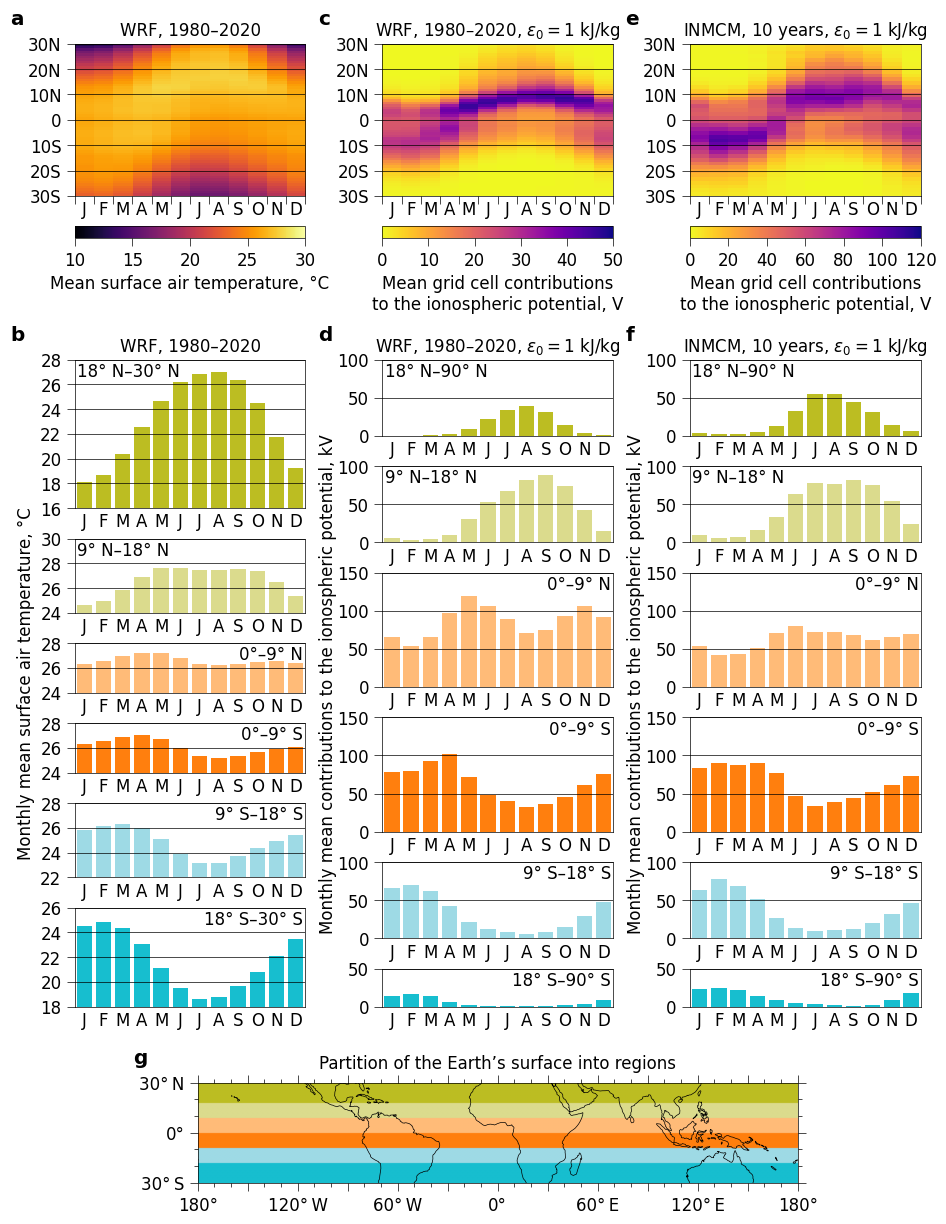

In [15]:
fig_width = 10
fig_height = 12

width = 3.
wsp = 1.
tot_width = 3 * width + 4 * wsp
widthM = 0.6 * tot_width

height = np.array([2., 2., 3., 3., 2., 1.])
hsp = 0.8
hsep1 = 2.
hsep2 = 3.5
assert len(height) == 6
heightD = 4.
heightM = widthM/tot_width * 60/360 * fig_width/fig_height
tot_height = (sum(height) + heightD + 8 * hsp + hsep1 + hsep2) / (1 - heightM)
heightM *= tot_height

sizeT = np.array([6., 3., 2., 2., 3., 4.])
hspT = hsp
assert len(sizeT) == 6
heightT = sizeT * (sum(height) + 5 * hsp - 5 * hspT) / sum(sizeT)
minT = np.array([16., 24., 24., 24., 22., 18.])

fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=False)

ax = [None for _ in range(12)]
axT = [None for _ in range(6)]

for n in range(6):
    ax[2*n] = fig.add_axes(
        (
            (width + 2 * wsp) / tot_width,
            (sum(height[n+1:]) + heightM + (6 - n) * hsp + hsep1) / tot_height,
            width / tot_width,
            height[n] / tot_height
        )
    )
    ax[2*n + 1] = fig.add_axes(
        (
            (2 * width + 3 * wsp) / tot_width,
            (sum(height[n+1:]) + heightM + (6 - n) * hsp + hsep1) / tot_height,
            width / tot_width,
            height[n] / tot_height
        )
    )
    axT[n] = fig.add_axes(
        (
            wsp / tot_width,
            (sum(heightT[n+1:]) + (5 - n) * hspT
             + heightM + hsp + hsep1) / tot_height,
            width / tot_width,
            heightT[n] / tot_height
        )
    )

axD = [None for _ in range(3)]

for n in range(3):
    axD[n] = fig.add_axes(
        (
            (n * width + (n + 1) * wsp) / tot_width,
            (sum(height) + heightM + 7 * hsp + hsep1 + hsep2) / tot_height,
            width / tot_width,
            heightD / tot_height
        )
    )

axM = fig.add_axes(
    (
        (1 - widthM / tot_width) / 2,
        hsp / tot_height,
        widthM / tot_width,
        heightM / tot_height
    ),
    projection=ccrs.PlateCarree(central_longitude=0)
)
axM.coastlines('110m', linewidth=0.5)

caption = ['WRF, 1980–2020, $\\varepsilon_0 = 1$ kJ/kg',
           'INMCM, 10 years, $\\varepsilon_0 = 1$ kJ/kg']

captionT = 'WRF, 1980–2020'

captionD = ['WRF, 1980–2020',
            'WRF, 1980–2020, $\\varepsilon_0 = 1$ kJ/kg',
            'INMCM, 10 years, $\\varepsilon_0 = 1$ kJ/kg']

for n in range(12):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis='y')
    ax[n].tick_params(length=0, width=0.5, axis='x')
    ax[n].grid(color='0.', linewidth=0.5, axis='y')

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize='large', va='top')

    low = 0
    high = 50e3 * height[n // 2]
    step = 50e3
    coeff = 1e3
    ax[n].set_ylim((low, high))
    ax[n].set_yticks(np.arange(low, high + step / 2, step))
    ax[n].set_yticklabels((np.arange(low, high + step / 1,
                                     step) / coeff).astype(int),
                          fontsize='large')

    if n < 2:
        ax[n].set_title(caption[n], fontsize='large')


for n in range(2):
    lbl = ax[n].set_ylabel('Monthly mean contributions '
                           'to the ionospheric potential, kV',
                           fontsize='large', labelpad=0.)
    lbl.set_position((0., 1 - (sum(height) + 5 * hsp) / 2 / height[0]))

for n in range(6):
    for axis in ['top', 'bottom', 'left', 'right']:
        axT[n].spines[axis].set_linewidth(0.5)
    axT[n].tick_params(length=6, width=0.5, axis='y')
    axT[n].tick_params(length=0, width=0.5, axis='x')
    axT[n].grid(color='0.', linewidth=0.5, axis='y')

    axT[n].set_xlim((-0.5, 11.5))
    axT[n].set_xticks(np.arange(12))
    axT[n].set_xticklabels(month_name, fontsize='large', va='top')

    low = minT[n]
    step = 2
    high = minT[n] + step * sizeT[n]
    coeff = 1
    axT[n].set_ylim((low, high))
    axT[n].set_yticks(np.arange(low, high + step / 2, step))
    axT[n].set_yticklabels((np.arange(low, high + step / 2,
                                      step) / coeff).astype(int),
                           fontsize='large')

    if n == 0:
        axT[n].set_title(captionT, fontsize='large')


lbl = axT[0].set_ylabel('Monthly mean surface air temperature, °C',
                        fontsize='large')
lbl.set_position((0., 1 - (sum(heightT) + 5 * hspT) / 2 / heightT[0]))

for n in range(3):
    for axis in ['top', 'bottom', 'left', 'right']:
        axD[n].spines[axis].set_linewidth(0.5)
    axD[n].tick_params(length=6, width=0.5)
    axD[n].tick_params(length=0, width=0.5, which='minor')
    axD[n].grid(color='0.', linewidth=0.5, axis='y')

    axD[n].set_xlim((0, 12))
    axD[n].set_xticks(np.arange(0, 12.5, 1))
    axD[n].set_xticks(np.arange(0.5, 12, 1), minor=True)
    axD[n].set_xticklabels([])
    axD[n].set_xticklabels(month_name, fontsize='large', va='top',
                           minor=True)

    axD[n].set_ylim((-30, 30))
    axD[n].set_yticks(np.arange(-30, 31, 10))
    axD[n].set_yticklabels(['0' if v == 0 else f'{-v}S' if v < 0 else f'{v}N'
                            for v in range(-30, 31, 10)],
                           fontsize='large')

    axD[n].set_title(captionD[n], fontsize='large')

cax = [None for _ in range(3)]
for n in range(3):
    cax[n] = fig.add_axes(
        [axD[n].get_position().x0,
         axD[n].get_position().y0 - 0.035,
         axD[n].get_position().x1 - axD[n].get_position().x0,
         0.01])

min_val = [10, 0, 0]
max_val = [30, 50, 120]
step_val = [5, 10, 20]
cbar_cmap = ['inferno', 'plasma_r', 'plasma_r']
cbar_norm = [None] * 3

for n in range(3):
    cbar_norm[n] = colors.Normalize(vmin=min_val[n], vmax=max_val[n])
    cbar = fig.colorbar(cm.ScalarMappable(norm=cbar_norm[n],
                                          cmap=cbar_cmap[n]),
                        cax=cax[n], orientation='horizontal')
    cbar.outline.set_linewidth(0.5)
    cbar.ax.tick_params(length=6, width=0.5)
    cbar.set_ticks(np.arange(min_val[n], max_val[n] + 1, step_val[n]))
    cbar.ax.set_xticklabels(['0' if v == 0 else f'−{-v}' if v < 0 else f'{v}'
                             for v in range(min_val[n], max_val[n] + 1,
                                            step_val[n])],
                            fontsize='large')
    if n == 0:
        cbar.set_label('Mean surface air temperature, °C',
                       fontsize='large')
    else:
        cbar.set_label('Mean grid cell contributions\n'
                       'to the ionospheric potential, V',
                       fontsize='large')

for axis in ['geo']:
    axM.spines[axis].set_linewidth(0.5)
axM.tick_params(top=True, right=True, which='both')
axM.tick_params(length=6, width=0.5)
axM.tick_params(length=3, width=0.5, which='minor')
axM.grid(False)

axM.set_xticks(np.arange(-180, 181, 30))
axM.set_xticks(np.arange(-180, 181, 10), minor=True)
axM.set_xticklabels(['180°', '', '120° W', '', '60° W', '', '0°',
                     '', '60° E', '', '120° E', '', '180°'],
                    fontsize='large', va='top')
# thin spaces (' ') are used between ‘°’ signs and letters

axM.set_yticks(np.arange(-90, 91, 30))
axM.set_yticks(np.arange(-90, 91, 10), minor=True)
axM.set_yticklabels(['', '', '30° S', '0°', '30° N', '', ''],
                    fontsize='large')
# thin spaces (' ') are used between ‘°’ signs and letters

axM.set_title('Partition of the Earth’s surface into regions',
              fontsize='large', pad=10)


#####################
### Plotting data ###
#####################

for j in range(6):
    ax[2*j].bar(range(12), wrf_ip_sum_over_bands[j],
                0.8, color=wrf_bands[j].color)

    ax[2*j+1].bar(range(12), inm_ip_sum_over_bands[j],
                0.8, color=inm_bands[j].color)

    axT[j].bar(range(12), wrf_t2_avg_over_bands[j],
                0.8, color=wrf_t2_bands[j].color)

    offset = lambda p: transforms.ScaledTranslation(0, p/72, fig.dpi_scale_trans)
    for AX in [ax[2*j], ax[2*j+1]]:
        AX.text(0.01 if j<2 else 0.99, 1,
               wrf_bands[j].title,
               fontsize='large', 
               ha='left' if j<2 else 'right', 
               va='top',
               transform=AX.transAxes + offset(-2))

    axT[j].text(0.01 if j<2 else 0.99, 1,
               wrf_t2_bands[j].title,
               fontsize='large', 
               ha='left' if j<2 else 'right', 
               va='top',
               transform=axT[j].transAxes + offset(-2))


axD[0].imshow(T2_LxM,
              cmap=cbar_cmap[0], norm=cbar_norm[0],
              extent=[0, 12, 30, -30], aspect='auto', interpolation='none',
              rasterized=True)
axD[1].imshow(WRF_IP_LxM,
              cmap=cbar_cmap[1], norm=cbar_norm[1],
              extent=[0, 12, 30, -30], aspect='auto', interpolation='none',
              rasterized=True)
axD[2].imshow(INM_IP_LxM,
              cmap=cbar_cmap[2], norm=cbar_norm[2],
              extent=[0, 12, 30, -30], aspect='auto', interpolation='none',
              rasterized=True)

axM.imshow(np.flip(strip_map[60:-60], axis=0), extent=[-180, 180, -30, 30])

for n in range(3):
    axD[n].text(-0.28 * width/width, 1 + 0.1 * heightD/heightD,
                chr(ord('a') + 2 * n), fontsize='x-large',
                fontweight='semibold', ha='left', va='bottom',
                transform=axD[n].transAxes)

axT[0].text(-0.28 * width/width, 1 + 0.1 * heightD/heightT[0],
            'b', fontsize='x-large',
            fontweight='semibold', ha='left', va='bottom',
            transform=axT[0].transAxes)

for n in range(2):
    ax[n].text(-0.28 * width/width, 1 + 0.1 * heightD/height[0],
               chr(ord('d') + 2 * n), fontsize='x-large',
               fontweight='semibold', ha='left', va='bottom',
               transform=ax[n].transAxes)

axM.text(-0.28 * width/widthM, 1 + 0.1 * heightD/heightM,
         'g', fontsize='x-large',
         fontweight='semibold', ha='left', va='bottom',
         transform=axM.transAxes)

fig.savefig('figures_two_parts/ip_separate.eps', bbox_inches='tight')

### Figure 6

In [16]:
vostok_diurnal = np.load('./data/Vostok/vostok_diurnal_2006_2020.npy')
vostok_seasonal = np.load('./data/Vostok/vostok_2006_2020_results.npz')['mean'][0]

In [17]:
wrf_diurnal = wrf_hourly_total_ip[1000].mean(axis=0) / 240e3
wrf_new_diurnal = wrf_hourly_total_ip[500].mean(axis=0) / 240e3
vostok_diurnal /= vostok_diurnal.mean()

In [18]:
# ring 
vostok_diurnal = [*vostok_diurnal, vostok_diurnal[0]]
wrf_new_diurnal = [*wrf_new_diurnal, wrf_new_diurnal[0]]
wrf_diurnal = [*wrf_diurnal, wrf_diurnal[0]]

In [19]:
band_names = ["0-9N", "0-9S", "9S-18S", "18S-90S", "9N-18N", "18N-90N"]
wrf_bands = [LatitudeBand(t, model="WRF") for t in band_names]
inmcm_bands = [LatitudeBand(t, model="INMCM") for t in band_names]

bar_data = np.zeros((2, len(band_names), 12))
# (axes, bands, months)

for i, band in enumerate(wrf_bands):
    bar_data[0, i] = wrf_LATxMON_ip[1000][band.slice].sum(axis=0)
    bar_data[1, i] = wrf_LATxMON_ip[500][band.slice].sum(axis=0)

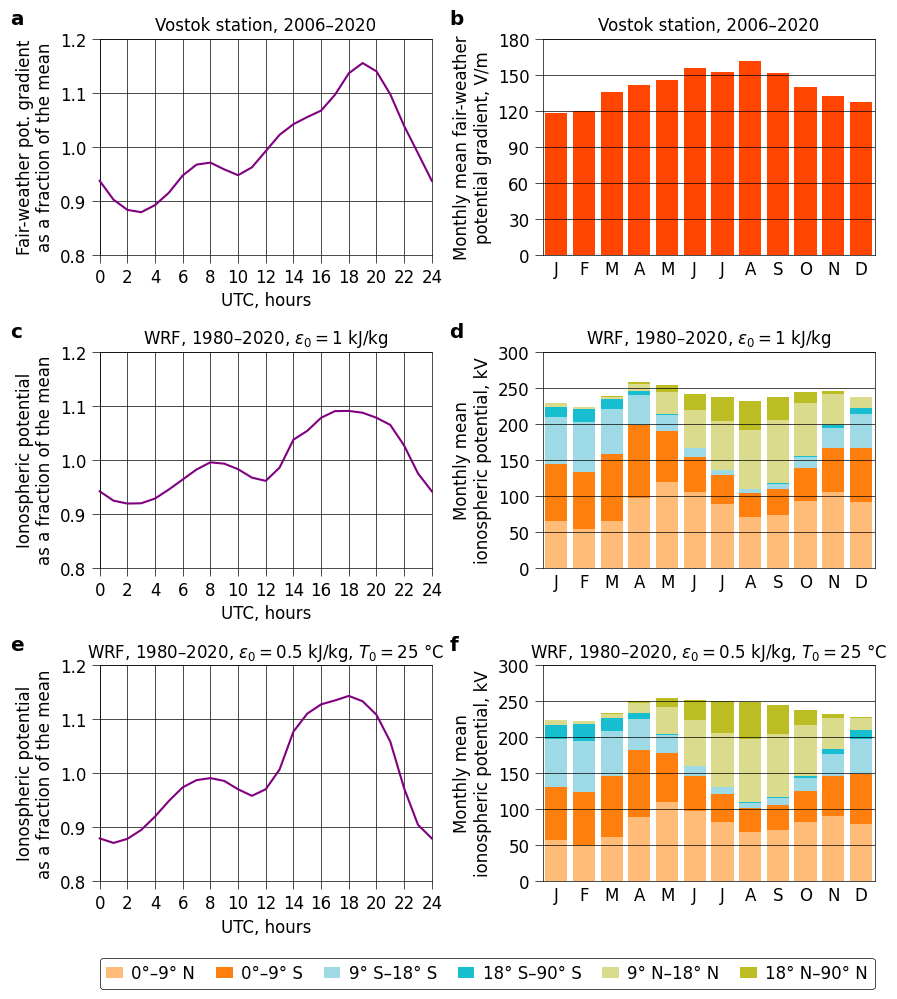

In [20]:
fig = plt.figure(figsize=(10, 15), constrained_layout=False)
ax = [None for _ in range(6)]
for n in range(6):
    ax[n] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))

low = [0.8, 0] + [0.8, 0e3] * 2
high = [1.2, 180] + [1.2, 300e3] * 2
step = [0.1, 30] + [0.1, 50e3] * 2
coeff = [1] * 2 + [1, 1e3] * 2
caption = ['Vostok station, 2006–2020',
           'Vostok station, 2006–2020',
           'WRF, 1980–2020, $\\varepsilon_0 = 1$ kJ/kg',
           'WRF, 1980–2020, $\\varepsilon_0 = 1$ kJ/kg',
           'WRF, 1980–2020, $\\varepsilon_0 = 0.5$ kJ/kg, $T_0 = 25$ °C',
           'WRF, 1980–2020, $\\varepsilon_0 = 0.5$ kJ/kg, $T_0 = 25$ °C']
lab = ['18° S–90° S',
       '9° S–18° S',
       '0°–9° S',
       '0°–9° N',
       '9° N–18° N',
       '18° N–90° N']
# thin spaces (' ') are used between ‘°’ signs and letters

for n in range(0, 5, 2):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5)
    ax[n].grid(color='0.', linewidth=0.5)

    ax[n].set_xlim((0, 24))
    ax[n].set_xticks(np.arange(0, 25, 2))
    ax[n].set_xticklabels(np.arange(0, 25, 2), fontsize='large')
    ax[n].set_xlabel('UTC, hours', fontsize='large')

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels([f'{x:.1f}' for x in
                           np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]],
                          fontsize='large')
    if n == 0:
        ax[n].set_ylabel('Fair-weather pot. gradient\n'
                         'as a fraction of the mean',
                     fontsize='large')
    else:
        ax[n].set_ylabel('Ionospheric potential\nas a fraction of the mean',
                         fontsize='large')

    ax[n].set_title(caption[n], fontsize='large')

for n in range(1, 6, 2):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis='y')
    ax[n].tick_params(length=0, width=0.5, axis='x')
    ax[n].grid(color='0.', linewidth=0.5, axis='y')

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize='large', va='top')

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize='large')
    if n == 1:
        ax[n].set_ylabel('Monthly mean fair-weather\npotential gradient, V/m',
                         fontsize='large')
    else:
        ax[n].set_ylabel('Monthly mean\nionospheric potential, kV',
                         fontsize='large')

    ax[n].set_title(caption[n], fontsize='large')

fig.align_ylabels([ax[0], ax[2], ax[4]])
fig.align_ylabels([ax[1], ax[3], ax[5]])

ax[0].plot(np.arange(0, 25),
           vostok_diurnal,
           linewidth=1.5, color='purple', clip_on=False,
           zorder=4)

ax[1].bar(np.arange(12), vostok_seasonal, 0.8, color='orangered')

ax[2].plot(np.arange(0, 25),
           wrf_diurnal,
           linewidth=1.5, color='purple', clip_on=False,
           zorder=4)
ax[4].plot(np.arange(0, 25),
           wrf_new_diurnal,
           linewidth=1.5, color='purple', clip_on=False,
           zorder=4)


for n in range(2):
    bottom_data = np.zeros(12)
    for k in range(len(band_names)):
        data = bar_data[n, k]
        ax[2*n+3].bar(
            np.arange(12),
            data,
            0.8,
            color=wrf_bands[k].color,
            bottom=bottom_data,
            label=wrf_bands[k].title,
        )
        bottom_data += data
        

for n in range(0, 5, 2):
    ax[n].text(-0.27, 1.05, chr(ord('a') + n),
               fontsize='x-large',
               fontweight='semibold', ha='left', va='bottom',
               transform=ax[n].transAxes)
for n in range(1, 6, 2):
    ax[n].text(-0.28, 1.05, chr(ord('a') + n),
               fontsize='x-large',
               fontweight='semibold', ha='left', va='bottom',
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.45, wspace=1.)

leg_width_rel = (ax[5].get_position().x1 - ax[4].get_position().x0) \
    / (ax[5].get_position().x1 - ax[5].get_position().x0)

leg = ax[5].legend(bbox_to_anchor=(1. - leg_width_rel, -1./2,
                                   leg_width_rel, 1./6), ncols=6,
                   loc='lower center', borderaxespad=0.,
                   mode='expand', fontsize='large',
                   framealpha=1, edgecolor='0.',
                   handlelength=1., handletextpad=0.5)
leg.get_frame().set_linewidth(0.5)

fig.savefig('figures_two_parts/new_parameterisation.eps', bbox_inches='tight')